# Estimation of molecular spectra using the Rodeo algorithm

Estimating the energy eigenvalues of a Hamiltonian is a fundamental task in quantum chemistry, material science and condensed matter physics. These eigenvalues provide critical insights into the underlying system, whether it be a molecule, material, or a more general quantum system. Many applications are based on the accurate estimation of the energy values like photodynamic therapy for cancer treatment, molecular drug design, and development of efficient energy storage devices.

Quantum computers main advantage will arguably be 'to simulate nature', thus they might offer a crucial advantage in estimating the energy values of Hamiltonians representing molecules, proteins, and materials. 

The [Rodeo Algorithm](https://arxiv.org/pdf/2009.04092) is a quantum algorithm for estimating the energy eigenvalues of any given Hamiltonian within a specified energy interval. In this project, we implemented it using the Classiq platform. Specifically we used the Rodeo algorithm to solve molecular Hamiltonians.

Roughly Speaking, the Rodeo Algorithm filters linearly spaced discrete sets of energies within a given interval, isolating and refining the true eigenvalues of the Hamiltonian. The algorithm can accurately identify energy levels by iteratively "sweeping" through the energy spectrum, making it a practical approach for quantum computations.

This is a scheme of the Rodeo Algorithm:

<div style="text-align: center;">
    <img src="https://docs.classiq.io/resources/rodeo2.png" alt="Rodeo.png" width="600" />
</div>

<p style="text-align: center;">
Fig.1 from the original paper: <a href="https://arxiv.org/pdf/2009.04092">Rodeo Algorithm for Quantum Computing</a> by Kenneth Choi et al.
</p>

## Initial Setup

Use the [regestration and installation](https://docs.classiq.io/latest/classiq_101/registration_installations/) page if you are having difficulty setting up your environment.\
Uncomment and run the following command to install or update to the latest version of the Classiq SDK (if not installed yet):

In [2]:
# pip install -U classiq

Uncomment and run the following command if your machine has not been authenticated yet:

In [3]:
# import classiq
# classiq.authenticate()

## Project structure

The project is composed of 2 task:

1. In the first task, we implement the algorithm to solve the simple Hamiltonian representing the H₂ molecule.
2. The second task will be to adapt the former implementation to a more complex Hamiltonian representing the H₂O molecule

Note that the Hamiltonians are given already in their Pauli form. And were provided during the 2024 PushQuantum Hackathon competition. Some assumptions were made to reduce the complexity and runtime for the sake of the hackathon

### The following is a little utility to save the quantum circuits to a file

In [4]:
def save_qprog(qprog, file_name):
    """
    A simple function that saves your quantum program (qprog) as a text file in a .qprog format.
    The function saves the qprog in the same directory as the current Python file you are working on.

    Inputs:
        - qprog: the quantum program (the returned value of the synthesize() function)
        - file_name: a string that determines the file name
    """
    file = open(file_name + ".qprog", "w")
    file.write(qprog)
    file.close()

# Part 1: H₂ molecule

In [5]:
import numpy as np
from classiq import *
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from classiq.execution import ExecutionSession

np.random.seed(0)  # Please don't change

# Define the 2D Hamiltonian
HAMILTONIAN = [
    PauliTerm([Pauli.I, Pauli.I], -1.0523),
    PauliTerm([Pauli.I, Pauli.Z], 0.3979),
    PauliTerm([Pauli.Z, Pauli.I], -0.3979),
    PauliTerm([Pauli.Z, Pauli.Z], -0.0112),
    PauliTerm([Pauli.X, Pauli.X], 0.1809),
]

hamiltonian_matrix = hamiltonian_to_matrix(HAMILTONIAN)
print(hamiltonian_matrix)

[[-1.0635+0.j  0.    +0.j  0.    +0.j  0.1809+0.j]
 [ 0.    +0.j -1.8369+0.j  0.1809+0.j  0.    +0.j]
 [ 0.    +0.j  0.1809+0.j -0.2453+0.j  0.    +0.j]
 [ 0.1809+0.j  0.    +0.j  0.    +0.j -1.0635+0.j]]


## Some utility for analytical calculation of the energy levels

In [6]:
def analytical_solution(hamiltonian):
    """
    Compute the analytical solution of the Hamiltonian.

    Returns:
        - eig_val: a list of eigenvalues
        - eig_vec: a list of eigenvectors
    """
    Hamiltonian_matrix = hamiltonian_to_matrix(hamiltonian)

    eig_val, eig_vec = np.linalg.eig(Hamiltonian_matrix)

    return eig_val, eig_vec.transpose()

In [7]:
def normalize(amps):
    return amps / np.linalg.norm(amps)

def get_uniform_superposition(eig_vecs):
    """
    Compute the uniform superposition of the eigenvectors.
    Args:
        - eig_vecs: a list of eigenvectors

    Returns:
        - vec: a list representing the uniform superposition of the eigenvectors
    """
    N = len(eig_vecs)
    
    # Ensure there is at least one eigenvector
    if N == 0:
        return []

    #transform each eig_vec into np.array()
    eig_vecs = [np.array(eig_vec) for eig_vec in eig_vecs]

    # make sum and multiply by 1/sqrt(N)
    superposition = np.sum(eig_vecs, axis=0) / np.sqrt(N)

    return normalize(superposition)

In [8]:
eig_val, eig_vecs = analytical_solution(HAMILTONIAN)

for i in range(len(eig_vecs)):
    print(f"Eigenvalue {i}: {eig_val[i]}")
    print(f"Eigenvector {i}: {eig_vecs[i]}")

uniform_superposition = get_uniform_superposition(eig_vecs)

print("Uniform superposition", uniform_superposition)

for i in range(len(eig_vecs)):
    inner_product = np.abs(np.dot(uniform_superposition, eig_vecs[i]))**2
    print(f"inner superposition with eigenvec {i}: {inner_product}")

Eigenvalue 0: (-0.8826+0j)
Eigenvector 0: [ 0.70710678+0.j -0.        -0.j -0.        -0.j  0.70710678-0.j]
Eigenvalue 1: (-1.2444000000000002+0j)
Eigenvector 1: [ 0.70710678+0.j  0.        +0.j  0.        +0.j -0.70710678+0.j]
Eigenvalue 2: (-0.22499801495156269+0j)
Eigenvector 2: [-0.        -0.j  0.11152752-0.j  0.99376135+0.j -0.        -0.j]
Eigenvalue 3: (-1.8572019850484374+0j)
Eigenvector 3: [-0.        -0.j  0.99376135+0.j -0.11152752-0.j -0.        -0.j]
Uniform superposition [ 7.07106781e-01+0.j  5.52644432e-01+0.j  4.41116914e-01+0.j
 -5.55111512e-17+0.j]
inner superposition with eigenvec 0: 0.2500000000000002
inner superposition with eigenvec 1: 0.2500000000000001
inner superposition with eigenvec 2: 0.25
inner superposition with eigenvec 3: 0.24999999999999994


## Rodeo Algorithm implementation (using analytical solution)

The first step is to implement the Rodeo algorithm to solve the simple Hamiltonian representing the H₂ molecule, using the information retrived by the analytical calculation to set the initial state and the energy interval.

In [9]:
np.random.seed(0)  # Please don't change

def get_t_n(T_RMS, N, tol=0.01):
    """
    Generate a list of N positive random numbers from a normal distribution with a given RMS value.
    The function repeats the generation until the RMS of the generated numbers is within a tolerance of tol.

    Args:
        T_RMS: Desired RMS value.
        N: Number of random numbers to generate.
        tol: Tolerance for the RMS difference (default: 1).
        
    Returns:
        t_n: A list of N positive random numbers.
    """
    while True:
        t_n = np.abs(np.random.normal(loc=0, scale=T_RMS, size=N)).tolist()
        calculated_rms = np.sqrt(np.mean(np.square(t_n)))
        if abs(calculated_rms - T_RMS) < tol:
            print(f"Calculated RMS (T_RMS={T_RMS}): {calculated_rms}")
            return t_n

def generate_input_data_sample(start, end, samples, T_RMS, N):
    """
    Generate input data for a full-range rodeo scan.
    
    Args:
        start: the start value of the energy range
        end: the end value of the energy range 
        samples: number of energy samples
        T_RMS, N: RMS value used to generate the t_n values
        
    Returns:
        energies: array of energy values
        data: list of dicts with each energy and associated t_n list
    """
    t_n = get_t_n(T_RMS, N)
    energies = np.linspace(start, end, samples)
    data = [{"E": e, "t1": t_n, "t2": t_n} for e in energies]
    return energies, data

def aggregate_counts(range_values, sample_result, N):
    """
    Aggregate the counts from the sample results.
    """
    result = {}
    for i, item in enumerate(sample_result):
        counts = item.counts
        aggregated = {}
        for key, value in counts.items():
            # Only the last N characters correspond to the ancilla register configuration
            agg_key = key[-N:]
            aggregated[agg_key] = aggregated.get(agg_key, 0) + value
        result[range_values[i]] = aggregated
    return result

In [10]:
def plot_sample(data,N,eig_val,title='Rodeo Scan', threshold=0.22, legend=True):
    x_values = []
    y_values = []

    # we are interested in the configuration of the ancilla that represents the eigenvalues if the hamiltonian
    # so the configuration that have N "1" in the ancilla register
    target = "0" * N

    for key, patterns in data.items():
        x_values.append(key)
        y_values.append(patterns.get(target, 0)/2048) # normalize the counts by the number of shots

    peaks, _ = find_peaks(y_values,height=threshold)

    # Plotting
    plt.figure(figsize=(10, 6))
    plt.plot(x_values, y_values, marker='o', linestyle='-', label='$P_n$')

    # Add vertical red lines at peaks
    for peak in peaks:
        plt.axvline(x=x_values[peak], color='red', linestyle='--', label=f'Peak at {x_values[peak]:.4f}')

    # Add vertical green line at correct eigenvalues
    for eigenvalue in eig_val:
        plt.axvline(x=eigenvalue, color='green', linestyle='-.', label=f'Eigenvalue at {eigenvalue:.4f}')

    plt.title(title)
    plt.xlabel('E')
    plt.ylabel('$P_N$')
    plt.grid(True)
    if legend:
        plt.legend(loc='best')
    plt.show()

In [11]:
@qfunc
def trotter(qbv: QArray[QBit], t: CInt):
    """
    Apply the Suzuki-Trotter decomposition to time evolution of the object Hamiltonian.
    """
    operator = [PauliTerm(term.pauli, term.coefficient * t) for term in HAMILTONIAN]
    suzuki_trotter(
        pauli_operator=operator,
        evolution_coefficient=1,
        order=1,
        repetitions=30,
        qbv=qbv
    )

@qfunc
def apply_control(ctrl: QBit, target: QArray, t: CInt):
    """
    Apply the controlled Suzuki-Trotter decomposition.
    """
    control(ctrl=ctrl, stmt_block=(lambda: trotter(target, t=t)))

In [36]:
N = 6
initial_vec = uniform_superposition

@qfunc
def main(a: Output[QArray], x: Output[QArray], E: CReal, t1: CArray[CReal, 6], t2: CArray[CReal, 6]):
    """
    Main quantum function implementing the Rodeo algorithm.
    """
    prepare_amplitudes(amplitudes=initial_vec, bound=0.01, out=x)
    allocate(N, a)
    # Prepare ancilla in the |+> state (using |0> state as default)
    hadamard_transform(a)
    # Apply controlled trotter evolution
    repeat(N, lambda i: apply_control(a[i], x, t=t1[i]))
    # Apply the phase rotation
    repeat(N, lambda i: phase(a[i], E*t2[i]))
    hadamard_transform(a)

qprog = synthesize(main)
execution_session = ExecutionSession(qprog)

In [37]:
T_RMS = 7
EMAX = -2
EMIN = 0
SAMPLES = 100

def rodeo(EMAX, EMIN, SAMPLES, T_RMS, N):
    energies, data = generate_input_data_sample(EMAX, EMIN, SAMPLES, T_RMS, N)
    raw_result = execution_session.batch_sample(data)
    return aggregate_counts(energies, raw_result, N)

result = rodeo(EMAX, EMIN, SAMPLES, T_RMS, N)

Calculated RMS (T_RMS=7): 6.9917992654876135


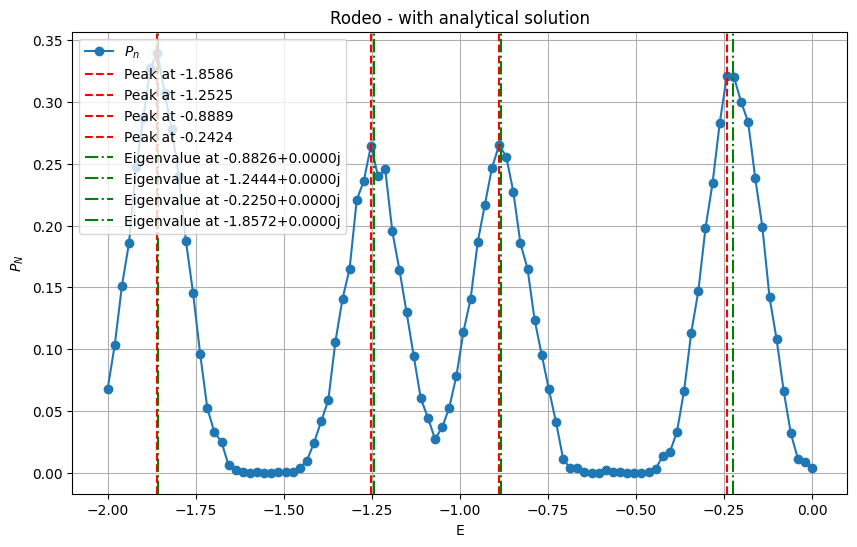

In [39]:
plot_sample(result,N,eig_val,title='Rodeo - with analytical solution', threshold=0.25, legend=True)

## Rodeo Algorithm (using estimated initial state and energy interval)

In [ ]:
N = 3
T_RMS = 7
EMIN = -2
EMAX=0 # manual correction
SAMPLES = 60
results = list()
guessed_vectors = [
    [0,1,0,0],
    [1,0,0,0],
    [0,0,0,1],
    [0,0,1,0],
]
for initial_vec in guessed_vectors:
    @qfunc
    def main(a: Output[QArray], x: Output[QArray], E: CReal, t1: CArray[CReal, 6], t2: CArray[CReal, 6]):
        """
        Main quantum function implementing the Rodeo algorithm.
        """
        prepare_amplitudes(amplitudes=initial_vec, bound=0.01, out=x)
        allocate(N, a)
        # Prepare ancilla in the |+> state (using |0> state as default)
        hadamard_transform(a)
        # Apply controlled trotter evolution
        repeat(N, lambda i: apply_control(a[i], x, t=t1[i]))
        # Apply the phase rotation
        repeat(N, lambda i: phase(a[i], E*t2[i]))
        hadamard_transform(a)

    qprog = synthesize(main)
    execution_session = ExecutionSession(qprog)


    def rodeo(EMAX, EMIN, SAMPLES, T_RMS, N):
        energies, data = generate_input_data_sample(EMAX, EMIN, SAMPLES, T_RMS, N)
        raw_result = execution_session.batch_sample(data)
        return aggregate_counts(energies, raw_result, N)

    results.append(rodeo(EMAX, EMIN, SAMPLES, T_RMS, N))

Calculated RMS (T_RMS=7): 7.000708294649554
Calculated RMS (T_RMS=7): 7.003324652710038
Calculated RMS (T_RMS=7): 6.990563637347417
Calculated RMS (T_RMS=7): 7.009914984225344


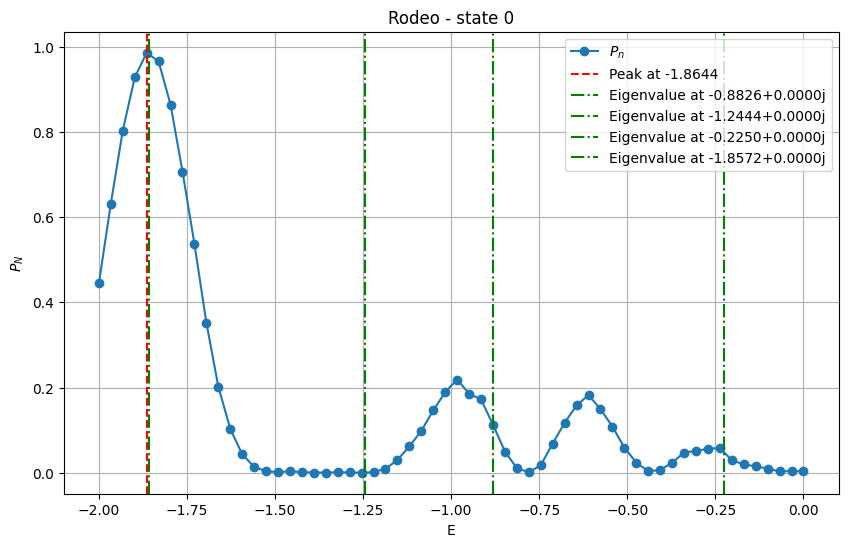

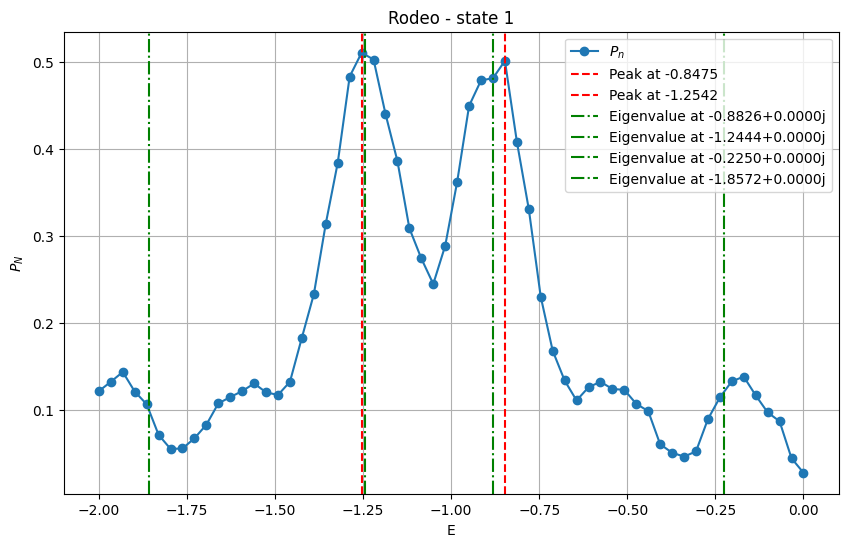

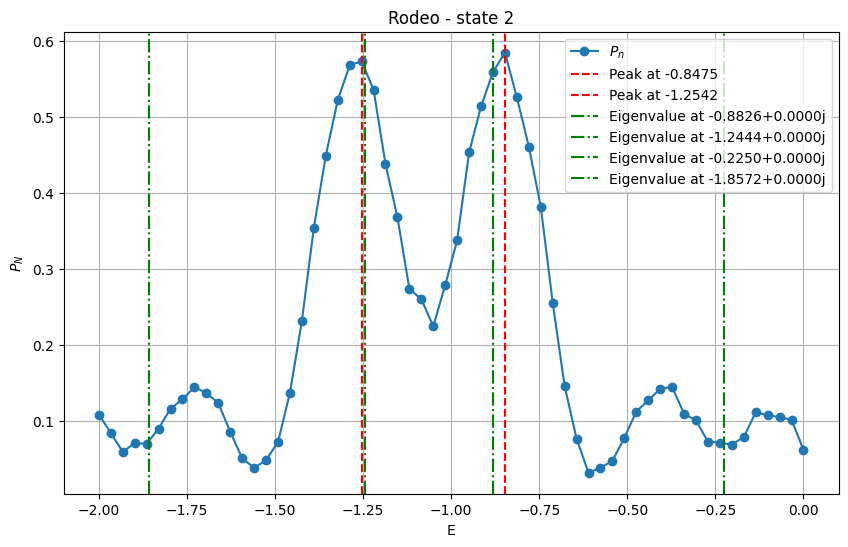

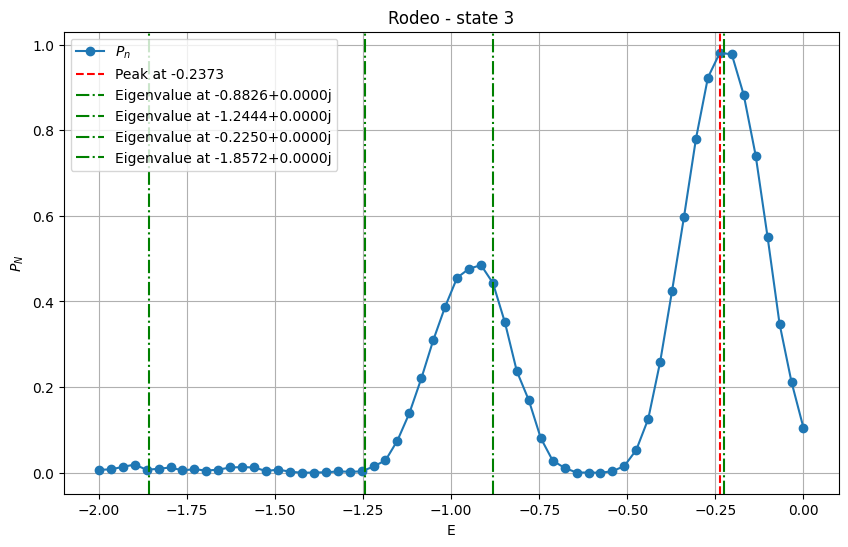

In [41]:
plot_sample(results[0],N,eig_val, title=f'Rodeo - state 0', threshold=0.90, legend=True)
plot_sample(results[1],N,eig_val, title=f'Rodeo - state 1', threshold=0.40, legend=True)
plot_sample(results[2],N,eig_val, title=f'Rodeo - state 2', threshold=0.40, legend=True)
plot_sample(results[3],N,eig_val, title=f'Rodeo - state 3', threshold=0.90, legend=True)

# Part 2: H₂O molecule

In this part, we extended the implementation of the Rodeo Algorithm to solve a more complex 6D Hamiltonian, which represents a reduced model of the water H₂O molecule.

The **goal is to find the five lowest energy levels of this Hamiltonian.**

In [12]:
np.random.seed(0)  # Please don't change

HAMILTONIAN = [
    PauliTerm([Pauli.I, Pauli.I, Pauli.I, Pauli.I, Pauli.I, Pauli.I], -12.533),
    PauliTerm([Pauli.Z, Pauli.I, Pauli.I, Pauli.Z, Pauli.I, Pauli.I], -1.276),
    PauliTerm([Pauli.Z, Pauli.Z, Pauli.I, Pauli.I, Pauli.I, Pauli.I], 0.627),
    PauliTerm([Pauli.I, Pauli.Z, Pauli.I, Pauli.I, Pauli.Z, Pauli.I], -0.875),
    PauliTerm([Pauli.I, Pauli.I, Pauli.Z, Pauli.Z, Pauli.I, Pauli.I], 0.452),
    PauliTerm([Pauli.X, Pauli.I, Pauli.X, Pauli.I, Pauli.I, Pauli.I], 0.182),
    PauliTerm([Pauli.I, Pauli.X, Pauli.I, Pauli.X, Pauli.I, Pauli.I], 0.139),
    PauliTerm([Pauli.Y, Pauli.Y, Pauli.I, Pauli.I, Pauli.I, Pauli.I], -0.047),
    PauliTerm([Pauli.Z, Pauli.I, Pauli.Z, Pauli.I, Pauli.Z, Pauli.I], 0.209),
    PauliTerm([Pauli.Z, Pauli.Z, Pauli.Z, Pauli.Z, Pauli.I, Pauli.I], -0.154),
    PauliTerm([Pauli.I, Pauli.Z, Pauli.I, Pauli.Z, Pauli.Z, Pauli.Z], 0.198),
    PauliTerm([Pauli.X, Pauli.I, Pauli.I, Pauli.I, Pauli.X, Pauli.I], 0.061),
    PauliTerm([Pauli.I, Pauli.I, Pauli.Y, Pauli.I, Pauli.Y, Pauli.I], -0.027),
    PauliTerm([Pauli.Z, Pauli.I, Pauli.Z, Pauli.Z, Pauli.I, Pauli.Z], 0.118),
]

## Analytical Solutions

In [13]:
eig_val, eig_vecs = analytical_solution(HAMILTONIAN)

eig_val = np.sort(eig_val)

for i in range(len(eig_vecs)):
    print(f"Eigenvalue {i}: {eig_val[i]}")
    print(f"Eigenvector {i}: {eig_vecs[i]}")

Eigenvalue 0: (-16.217433552022165+0j)
Eigenvector 0: [-9.93586785e-05-0.j  1.64722763e-17-0.j -1.41630833e-16-0.j
  5.31975534e-17-0.j -1.20795660e-16-0.j -1.38838103e-16-0.j
 -1.00897770e-02-0.j  9.09022545e-16-0.j  1.03449440e-15-0.j
  1.38856984e-16-0.j  1.18987939e-06-0.j -1.91829055e-18-0.j
 -3.86506667e-02-0.j  2.26161400e-15-0.j  3.47905849e-16-0.j
  4.28642227e-19-0.j  5.95125605e-18-0.j  7.02804199e-18-0.j
  1.79395144e-03-0.j -2.60232837e-16-0.j  9.60126456e-03-0.j
 -6.02056653e-16-0.j  7.85492622e-18-0.j -2.94981946e-18-0.j
  6.22883776e-03-0.j -2.72010904e-16-0.j  5.84129651e-18-0.j
 -1.07854331e-18-0.j -2.56453817e-17-0.j -3.23479181e-18-0.j
 -1.41742587e-04-0.j  9.04589734e-18-0.j -4.77332288e-17-0.j
 -7.16446217e-18-0.j  1.73024249e-05-0.j -2.01259566e-18-0.j
  9.98855511e-01+0.j -5.84941939e-14-0.j  1.68337846e-17-0.j
  5.22734021e-18-0.j  9.15662421e-05-0.j -5.77669326e-18-0.j
 -8.61928187e-18-0.j -3.78295723e-18-0.j  9.20018529e-18-0.j
  1.44954141e-17-0.j -7.2794794

## Rodeo Algorithm for H₂O molecule

In [ ]:
N = 4
T_RMS = 7
EMIN = -16.30
EMAX = -15
SAMPLES = 50
results = list()
guessed_vectors = []
vec = np.zeros(64)
vec[36]=1
guessed_vectors.append(vec)

vec = np.zeros(64)
vec[37]=1
guessed_vectors.append(vec)

vec = np.zeros(64)
vec[27]=1
guessed_vectors.append(vec)

vec = np.zeros(64)
vec[26]=1
guessed_vectors.append(vec)

vec = np.zeros(64)
vec[19]=1
guessed_vectors.append(vec)

for j,initial_vec in enumerate(guessed_vectors):
    @qfunc
    def main(a: Output[QArray], x: Output[QArray], E: CReal, t1: CArray[CReal, 6], t2: CArray[CReal, 6]):
        """
        Main quantum function implementing the Rodeo algorithm.
        """
        prepare_amplitudes(amplitudes=initial_vec, bound=0.01, out=x)
        allocate(N, a)
        # Prepare ancilla in the |+> state (using |0> state as default)
        hadamard_transform(a)
        # Apply controlled trotter evolution
        repeat(N, lambda i: apply_control(a[i], x, t=t1[i]))
        # Apply the phase rotation
        repeat(N, lambda i: phase(a[i], E*t2[i]))
        hadamard_transform(a)

    qprog = synthesize(main)
    execution_session = ExecutionSession(qprog)


    def rodeo(EMAX, EMIN, SAMPLES, T_RMS, N):
        energies, data = generate_input_data_sample(EMAX, EMIN, SAMPLES, T_RMS, N)
        raw_result = execution_session.batch_sample(data)
        return aggregate_counts(energies, raw_result, N)

    result = rodeo(EMAX, EMIN, SAMPLES, T_RMS, N)

    filename=f"results_{N}_{T_RMS}_{j}.txt"
    with open(filename
    , 'w') as f:
        f.write(str(result))

    results.append(result)

Calculated RMS (T_RMS=13): 13.007114325543538
Calculated RMS (T_RMS=13): 12.996842938014149
Calculated RMS (T_RMS=13): 13.004784707457741
Calculated RMS (T_RMS=13): 13.001547765504023
Calculated RMS (T_RMS=13): 13.007156792324102


/Users/babeldev/miniforge3/lib/python3.12/site-packages/matplotlib/cbook.py:1355: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


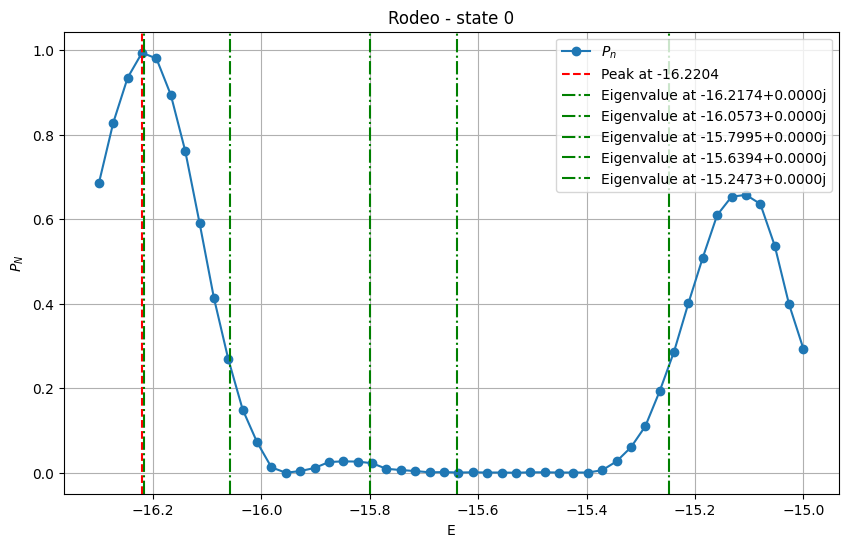

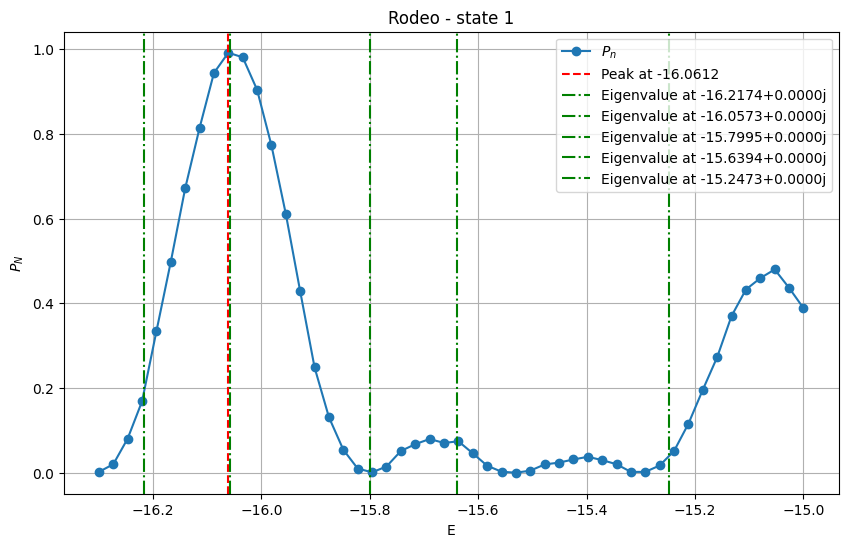

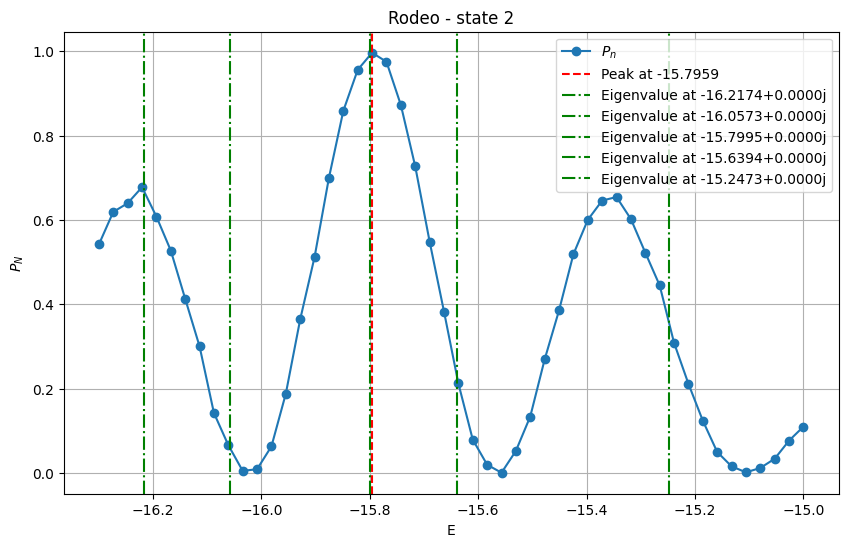

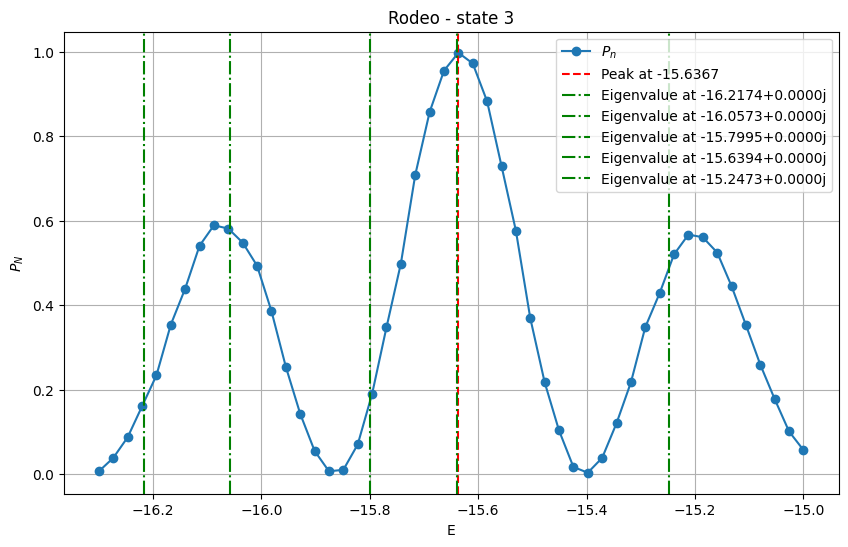

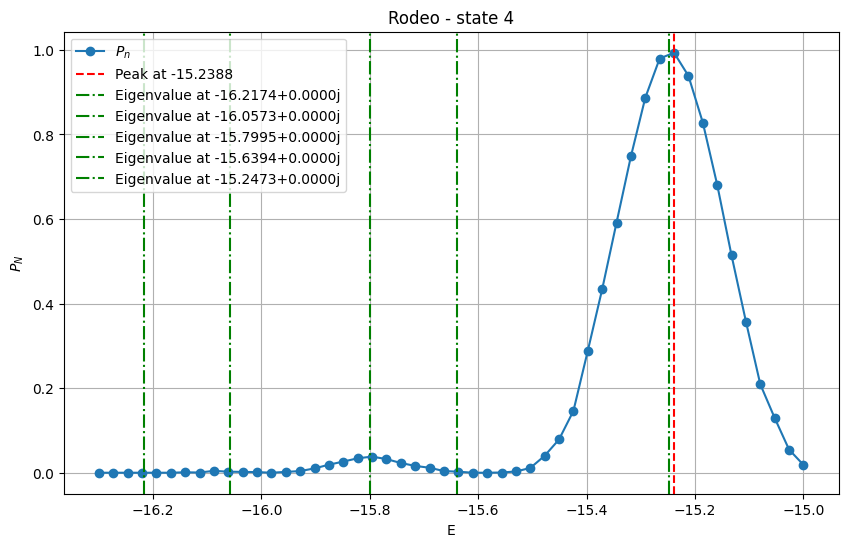

In [23]:
results=list()
for i in range(5):
    filename=f"results_{N}_{T_RMS}_{i}.txt"
    with open(filename, 'r') as f:
        result = eval(f.read())
        results.append(result)

plot_sample(results[0],N, eig_val[0:5],title='Rodeo - state 0', threshold=0.90, legend=True)
plot_sample(results[1],N, eig_val[0:5],title='Rodeo - state 1', threshold=0.80, legend=True)
plot_sample(results[2],N, eig_val[0:5],title='Rodeo - state 2', threshold=0.90, legend=True)
plot_sample(results[3],N, eig_val[0:5],title='Rodeo - state 3', threshold=0.60, legend=True)
plot_sample(results[4],N, eig_val[0:5],title='Rodeo - state 4', threshold=0.90, legend=True)